In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
FONT_SIZE = 17

from random import shuffle, seed
SEED_NUMBER=42

from pathlib import Path

In [2]:
proj_path = Path().resolve().parent.parent
proj_path = proj_path / "results"
print(proj_path)

/home/mommess/Documents/Leeds_research/VectorPacking_journal/results


In [3]:
file_G = proj_path / "1dim/Gupta_dim1.csv"
file_DI = proj_path / "1dim/BPPLIB_Difficult_Instances_dim1.csv"
file_F = proj_path / "1dim/BPPLIB_Falkenauer_dim1_OPT.csv"
file_H28 = proj_path / "1dim/BPPLIB_Hard28_dim1_OPT.csv"
file_I = proj_path / "1dim/BPPLIB_Irnich_dim1_OPT.csv"
file_S = proj_path / "1dim/BPPLIB_Scholl_dim1_OPT.csv"
file_Sw = proj_path / "1dim/BPPLIB_Schwerin_dim1_OPT.csv"
file_W = proj_path / "1dim/BPPLIB_Waescher_dim1_OPT.csv"

In [4]:
def load_df(filename, with_OPT=True, with_BIM=True):
    df = pd.read_csv(filename, sep='\t')
    if with_OPT:
        # First 3 columns are ['instance_name', 'LB', 'OPT']
        start_cols = 3
    else:
        start_cols = 2
        # First 2 columns are ['instance_name', 'LB']
    alg_column_names = df.columns[start_cols:]

    if (len(alg_column_names) % 2) != 0:
        print(f"ERROR: {len(alg_column_names)} {len(df.columns)}")

    nb_algos = int(len(alg_column_names)/2)
    alg_names = alg_column_names[:nb_algos]
    
    for x in alg_names:
        if '.' in x:
            print("Error ALGO NAME:", x)
            
    # Replace '-1' values by the FF solutions in MB algos
    if with_BIM:
        algos_MB = ["WFDm", "BIM-DP1", "BIM-DP2", "BIM-DP3", "BIM-NormDP"]
    else:
        algos_MB = ["WFDm"]
    for alg in algos_MB:
        if alg in df.columns:
            df.loc[df[alg] == -1, alg] = df['FF']
    
    if "OPT" in df.columns:
        df.rename(columns={"OPT":"LB_or_OPT"}, inplace=True)
    else:
        df.insert(2, 'LB_or_OPT', df["LB"])
    
    return df, list(alg_names)

In [53]:
def get_results(df, alg_names):
    best_sol = df[alg_names].min(axis=1)

    time_cols = [i+'_timems' for i in alg_names]
    
    eps = df[alg_names].apply(lambda x: (round(x / df["LB_or_OPT"] - 1, 3))*100) # *100 to get a percentage value
    time = df[time_cols].apply(lambda x: round(x, 4))
    time.columns = alg_names
    #diff = df[alg_names].apply(lambda x: x - df["LB_or_OPT"])
    #diff_best = df[alg_names].apply(lambda x: x - best_sol)
    
    #match_LB = df[alg_names].apply(lambda x: x == df["LB"])
    #best = df[alg_names].apply(lambda x: x == best_sol)

    return eps, time#, diff, diff_best, best, match_LB

In [52]:
def get_results_by(df, alg_names, by_list, group_as_index=False):
    sub_df = df[by_list].copy()
    
    best_sol = df[alg_names].min(axis=1)

    time_cols = [i+'_timems' for i in alg_names]
    
    eps = df[alg_names].apply(lambda x: (round(x / df["LB_or_OPT"] - 1, 3))*100) # *100 to get a percentage value
    time = df[time_cols].apply(lambda x: round(x, 4))
    time.columns = alg_names
    #diff = df[alg_names].apply(lambda x: x - df["LB_or_OPT"])
    #diff_best = df[alg_names].apply(lambda x: x - best_sol)
    
    #match_LB = df[alg_names].apply(lambda x: x == df["LB"])
    #best = df[alg_names].apply(lambda x: x == best_sol)
    
    eps = pd.concat([sub_df, eps], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    time = pd.concat([sub_df, time], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    #diff = pd.concat([sub_df, diff], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    #diff_best = pd.concat([sub_df, diff_best], axis=1).groupby(by=by_list, as_index=group_as_index).mean()
    
    #best = pd.concat([sub_df, best], axis=1).groupby(by=by_list, as_index=group_as_index).sum()
    #match_LB = pd.concat([sub_df, match_LB], axis=1).groupby(by=by_list, as_index=group_as_index).sum()
    
    return eps, time#, diff, diff_best, best, match_LB

## Load datasets and get results

In [54]:
#df_G, alg_names = load_df(file_G, with_OPT=False)
df_DI, alg_names = load_df(file_DI, with_OPT=False)

df_F, _ = load_df(file_F, with_OPT=True)
df_H28, _ = load_df(file_H28, with_OPT=True)
df_S, _ = load_df(file_S, with_OPT=True)
df_Sw, _ = load_df(file_Sw, with_OPT=True)
df_W, _ = load_df(file_W, with_OPT=True)

df_I, alg_names_short = load_df(file_I, with_OPT=True, with_BIM=False)

In [55]:
# remove redundant algos
to_remove = ['BCS-DP1', 'BCS-NormDP', 'BCS-TFSum', 'BIM-DP1', 'BIM-NormDP'] # They behave as other algos
alg_names = [x for x in alg_names if not x in to_remove]
alg_names_short = [x for x in alg_names_short if not x in to_remove]

In [56]:
#results_G = get_results(df_G, alg_names) # Almost all algos match LB
#results_DI = get_results(df_DI, alg_names) # has 2 classes
#results_F = get_results(df_F, alg_names) # has classes
results_H28 = get_results(df_H28, alg_names)
#results_S = get_results(df_S, alg_names) # has classes
#results_Sw = get_results(df_Sw, alg_names) # has classes
results_W = get_results(df_W, alg_names)

results_I = get_results(df_I, alg_names_short)

In [57]:
# 2 classes of difficult instances
df_DI["class"] = df_DI["instance_name"].apply(lambda x: x.split('_')[2])
results_ANI = get_results(df_DI[df_DI["class"] == "NR"], alg_names)
results_AI = get_results(df_DI[df_DI["class"] == "DI"], alg_names)

In [58]:
# Falkenauer has 2 classes
df_F["class"] = df_F["instance_name"].apply(lambda x: x.split('_')[1][0].upper())
results_FT = get_results(df_F[df_F["class"] == "T"], alg_names)
results_FU = get_results(df_F[df_F["class"] == "U"], alg_names)

In [59]:
def get_Scholl_class(x):
    if x[2] == "C":
        return "1"
    elif x[2] == "W":
        return "2"
    elif x[2] == "R":
        return "3"
    else:
        return "0"

In [60]:
# Scholl has 3 classes
df_S["class"] = df_S["instance_name"].apply(lambda x: get_Scholl_class(x))
results_S1 = get_results(df_S[df_S["class"] == "1"], alg_names)
results_S2 = get_results(df_S[df_S["class"] == "2"], alg_names)
results_S3 = get_results(df_S[df_S["class"] == "3"], alg_names)

In [61]:
# Schwerwin has 2 classes
df_Sw["class"] = df_Sw["instance_name"].apply(lambda x: x[8])
results_Sw1 = get_results(df_Sw[df_Sw["class"] == "1"], alg_names)
results_Sw2 = get_results(df_Sw[df_Sw["class"] == "2"], alg_names)

In [62]:
dict_res = {
    "Difficult ANI": (results_ANI, "ANI"),
    "Difficult AI": (results_AI, "AI"),
    "Falkenauer Triplets": (results_FT, "FT"),
    "Falkenauer Uniform": (results_FU, "FU"),
    "Hard 28": (results_H28, "H28"),
    "Scholl class 1": (results_S1, "S1"),
    "Scholl class 2": (results_S2, "S2"),
    "Scholl class 3": (results_S3, "S3"),
    "Schwerin class 1": (results_Sw1, "Sw1"),
    "Schwerin class 2": (results_Sw2, "Sw2"),
    "Waescher": (results_W, "W"),
}

## Check algorithms performing equally

In [90]:
big_df = pd.concat([df_DI, df_F, df_S, df_W, df_Sw, df_H28])

In [91]:
big_df.shape

(2115, 34)

In [247]:
l = ["BCS-DP1", "BCS-DP2",
     "BCS-NormDP", "BCS-L2Norm",
     "BCS-TFSum", "BCS-TFMin",
     "WFDm",
     "BIM-DP1", "BIM-DP2", "BIM-DP3",
     "BIM-NormDP"
]

In [53]:
nb_instances = big_df.shape[0]

In [59]:
for algo_test in alg_names:
    counts = big_df[alg_names].apply(lambda x: x == big_df[algo_test]).sum()
    ll = list(counts[counts == nb_instances].index)
    ll.remove(algo_test)
    if (len(ll) > 0):
        print(f"{algo_test}: {ll}")

FFD: ['BCS-DP1', 'BCS-NormDP', 'BCS-TFSum']
BCS-DP1: ['FFD', 'BCS-NormDP', 'BCS-TFSum']
BCS-NormDP: ['FFD', 'BCS-DP1', 'BCS-TFSum']
BCS-TFSum: ['FFD', 'BCS-DP1', 'BCS-NormDP']
BIM-DP1: ['BIM-NormDP', 'WFDm']
BIM-NormDP: ['BIM-DP1', 'WFDm']
WFDm: ['BIM-DP1', 'BIM-NormDP']


In [92]:
def my_sup(x):
    return x[x > 0].count()

def my_eq(x):
    return x[x == 0].count()

def my_low(x):
    return x[x < 0].count()

def make_diff(df, list1, list2):
    a = df[list1]
    b = df[list2]
    b.columns = a.columns
    df_diff = (a - b).agg(['mean', 'std', my_sup, my_eq, my_low])
    return df_diff

In [97]:
make_diff(big_df, ['BCS-TFMin'], ['BCS-TFSum'])

,BCS-TFMin
mean,4.444444
std,4.983712
my_sup,1556.000000
my_eq,449.000000
my_low,110.000000


In [98]:
make_diff(big_df, ['BIM-DP2'], ['BIM-DP3'])

,BIM-DP2
mean,3.336170
std,3.471058
my_sup,1542.000000
my_eq,537.000000
my_low,36.000000


In [107]:
make_diff(big_df, ['BIM-DP2'], ['BIM-DP1'])

,BIM-DP2
mean,2.395745
std,3.053432
my_sup,1171.000000
my_eq,935.000000
my_low,9.000000


In [114]:
make_diff(big_df, ['BIM-DP2'], ['FF'])

,BIM-DP2
mean,-0.035934
std,0.223150
my_sup,0.000000
my_eq,2053.000000
my_low,62.000000


In [111]:
make_diff(big_df, ['FFD'], ['BCS-L2Norm'])

,FFD
mean,-9.076596
std,12.358022
my_sup,46.000000
my_eq,534.000000
my_low,1535.000000


## Plots

In [63]:
def create_small_colors(n):
    cmap = cm.get_cmap('turbo')
    n+=1
    if n > 1:
        c = []
        for i in range(n):
            c.append(cmap(float(i/(n-1))))
        #shuffle(c)
    else:
        c = [cmap(0)]
    return c[1:]

In [64]:
def plot_barchart(df, alg_names, 
                  title,
                  fname=None):
    x = np.arange(len(alg_names))
    
    color_list = create_small_colors(len(alg_names))
    
    fig = plt.figure(figsize=(15,10))

    plt.bar(x, df.mean(), yerr=df.std(), color=color_list, capsize=10)
    plt.xticks(x, alg_names, rotation=45, fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.ylabel("% error to LB", fontsize=FONT_SIZE+8)
    plt.title(title, fontsize=FONT_SIZE+8)

    plt.show()
    
    if fname:
        fig.savefig(fname, bbox_inches='tight')

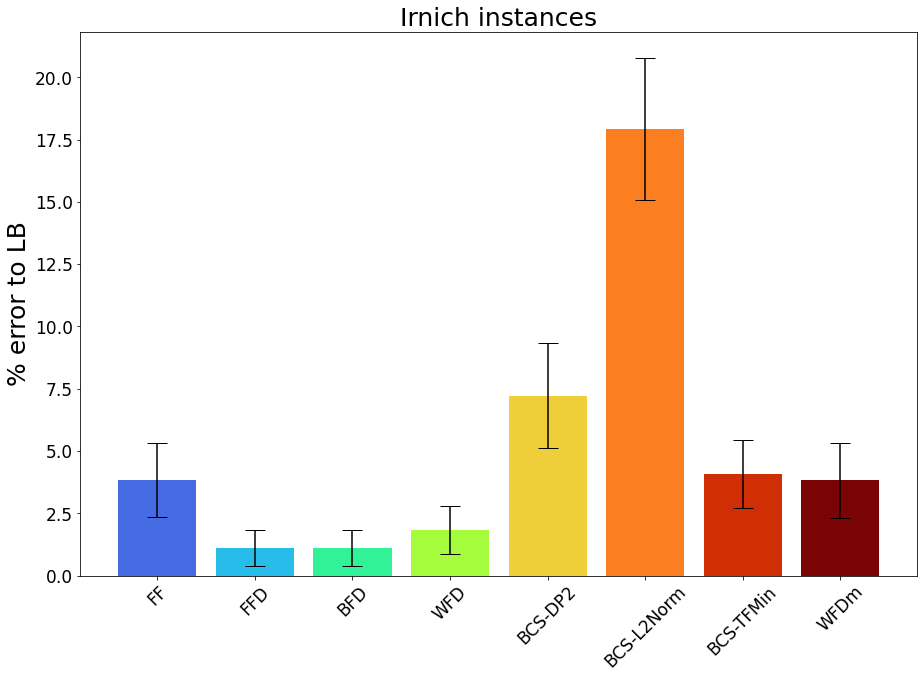

In [65]:
fname = proj_path / "plots/1dim/Irnich_barplot.pdf"
plot_barchart(results_I[0], alg_names_short,
              "Irnich instances",
              fname=fname)

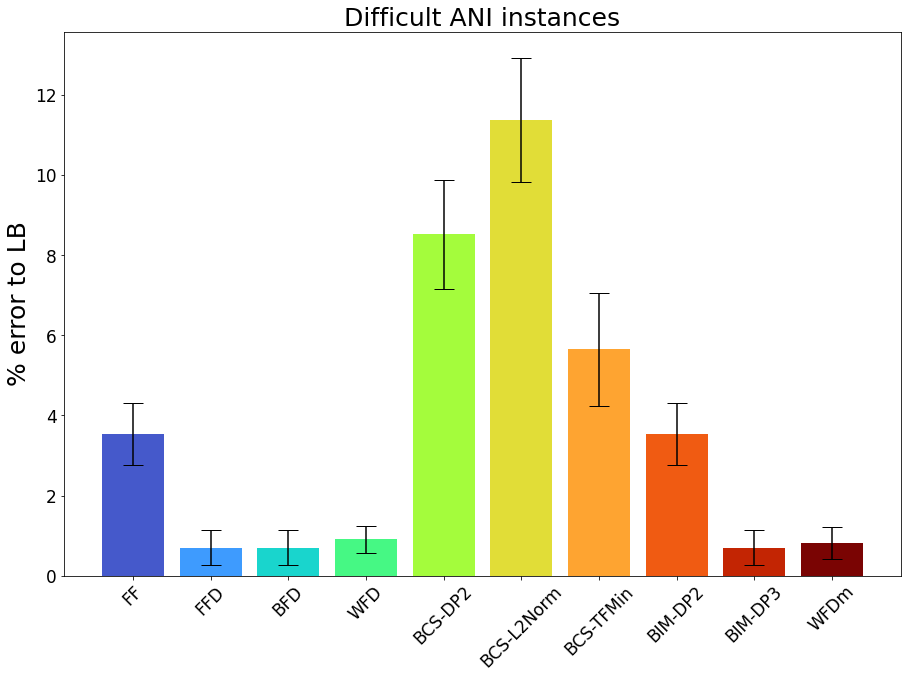

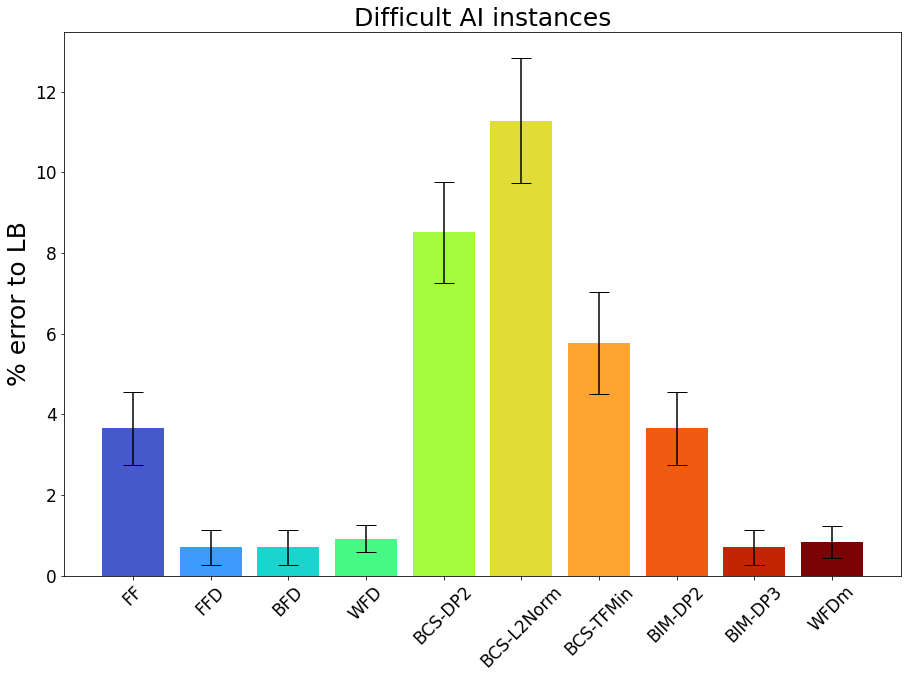

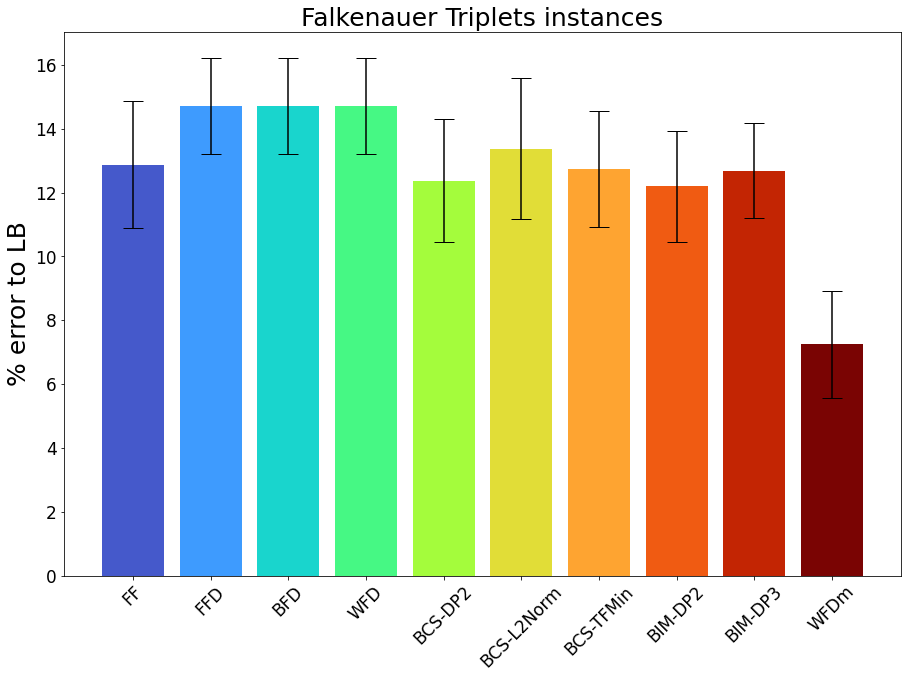

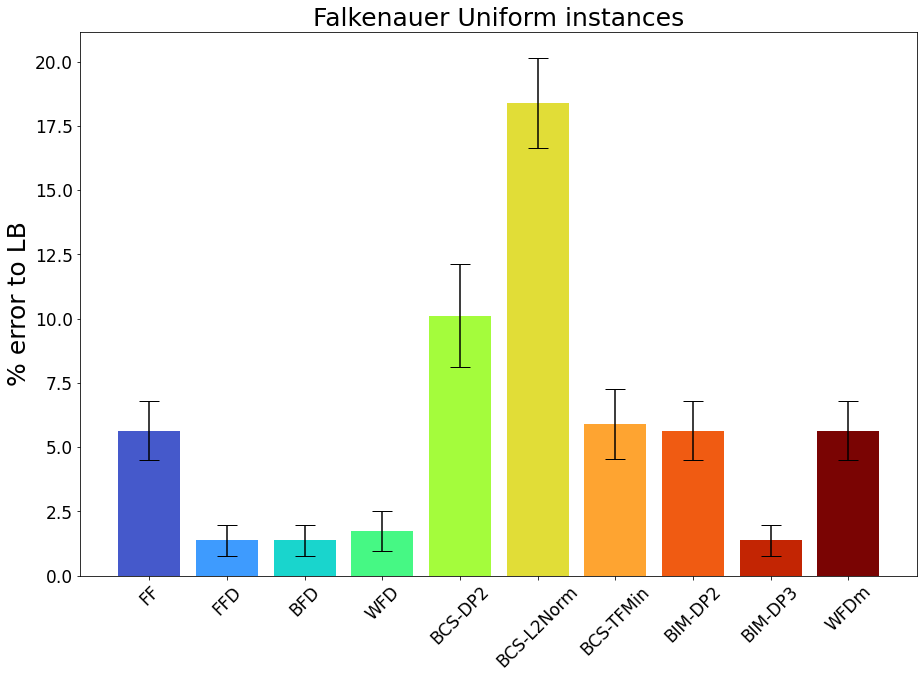

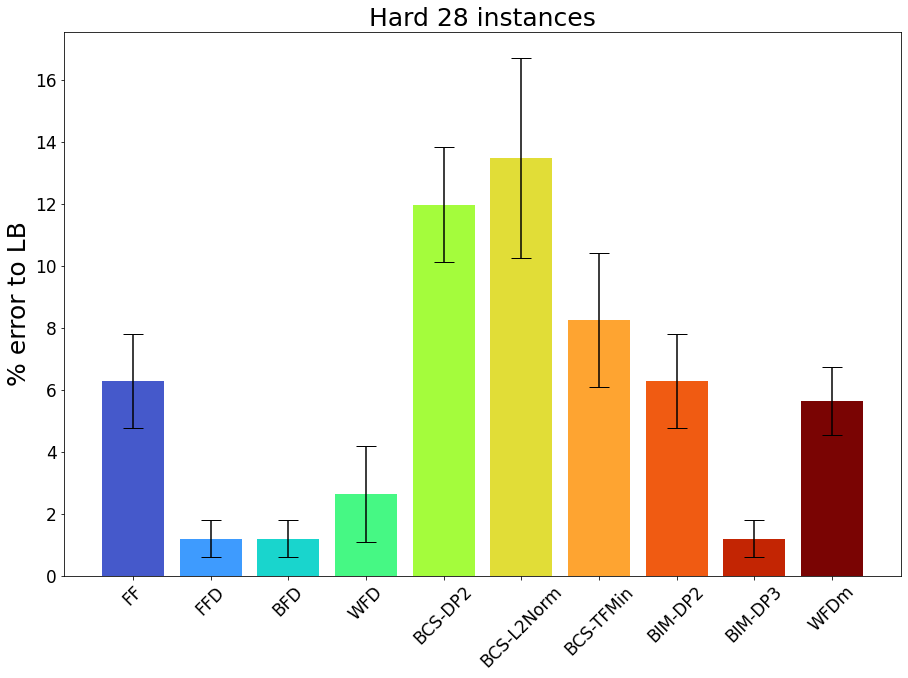

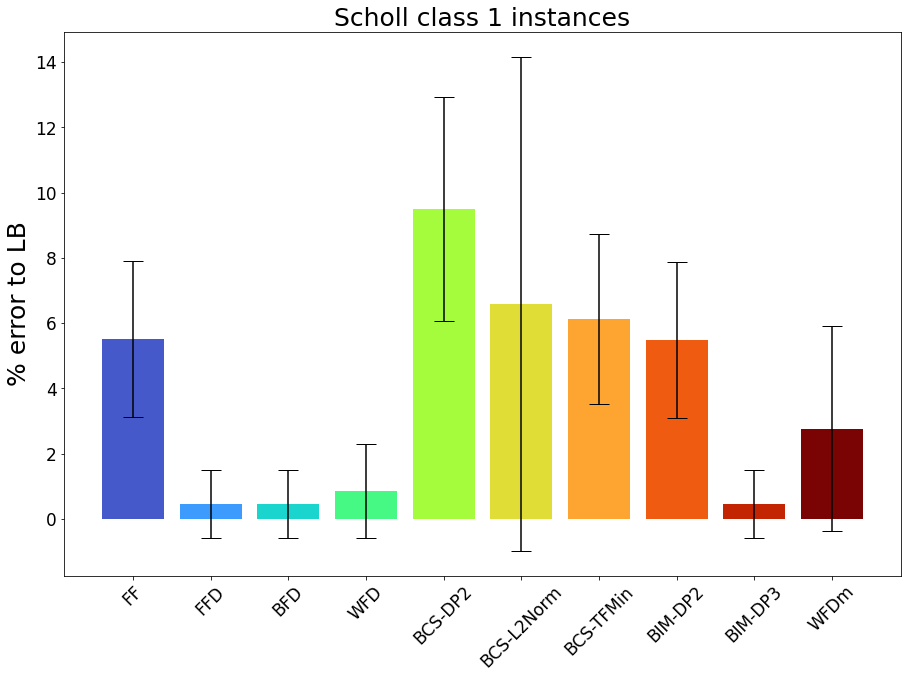

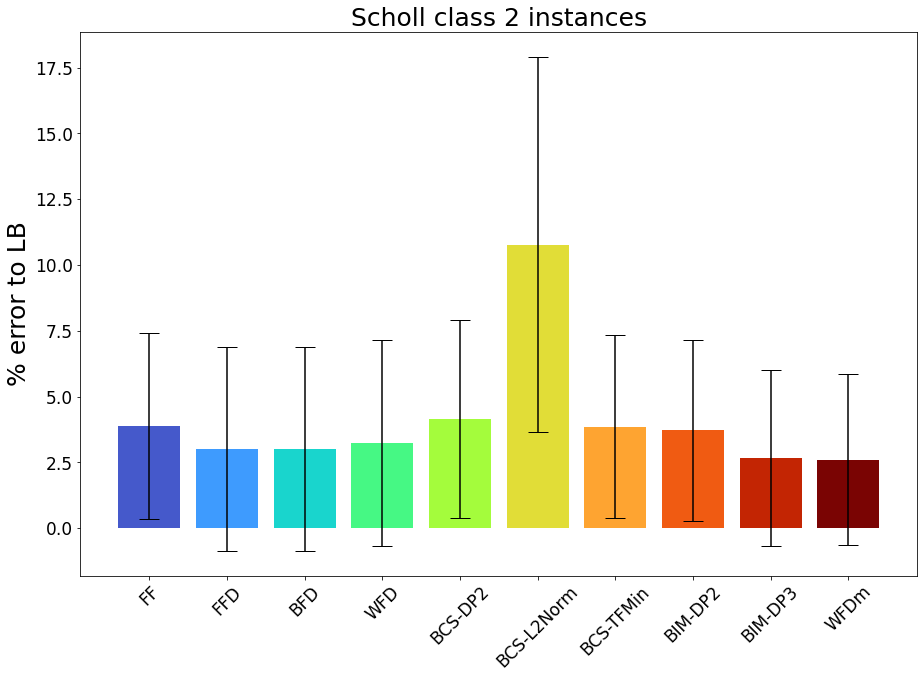

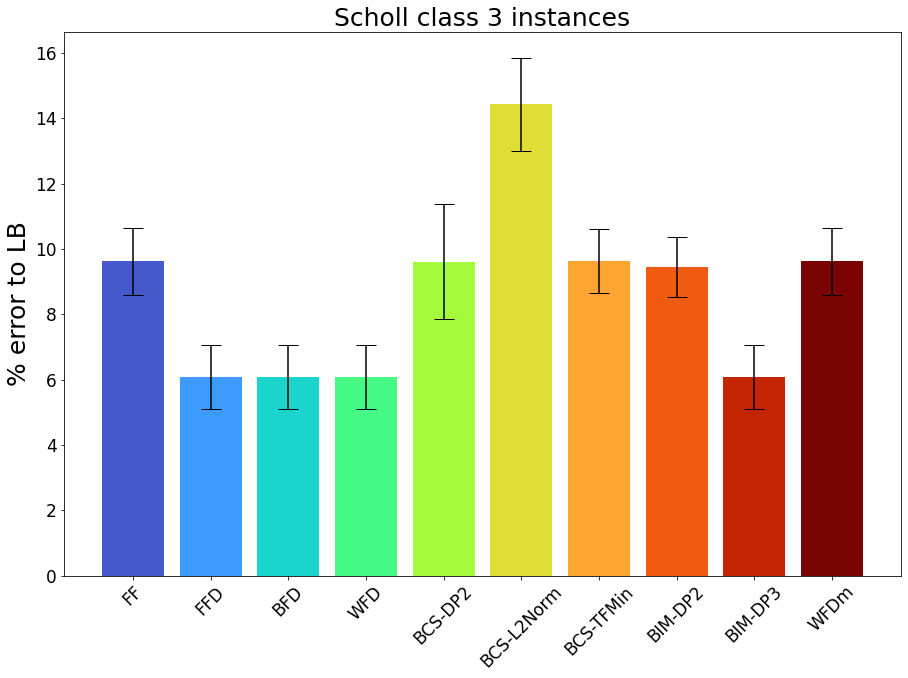

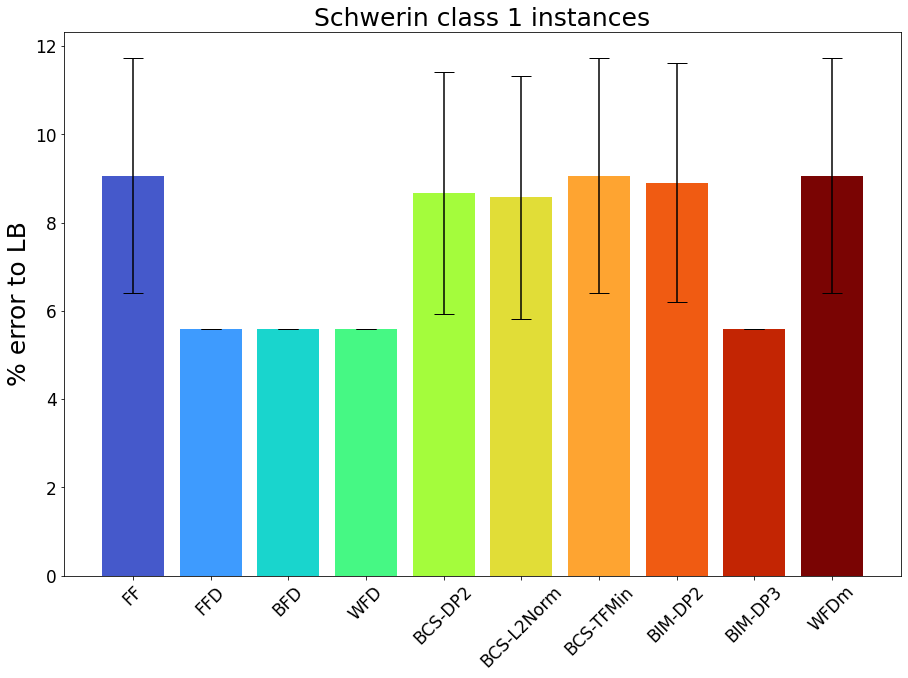

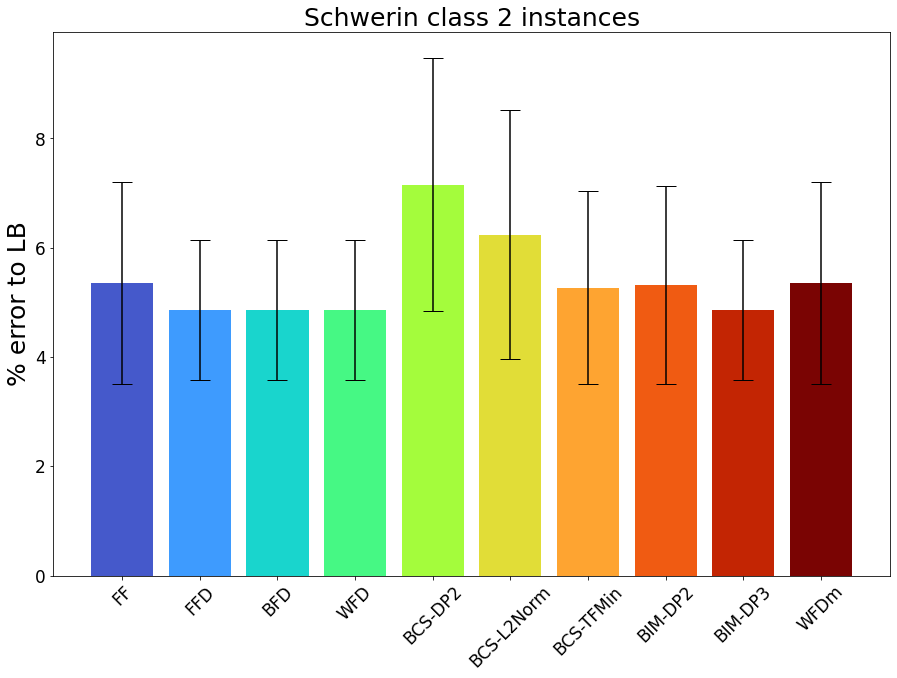

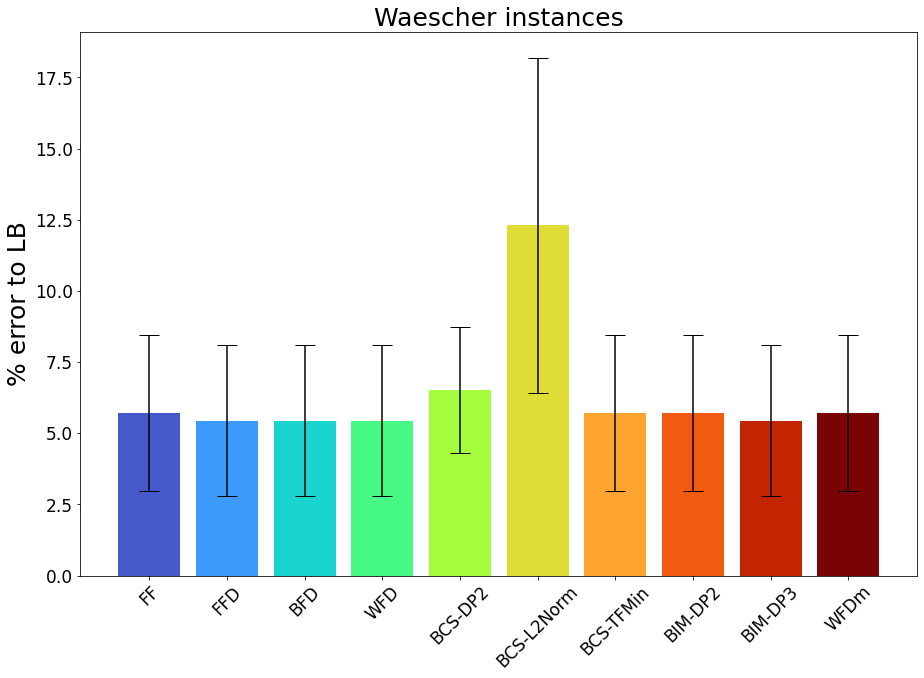

In [75]:
for name, (results, short_name) in dict_res.items():
    fname = proj_path / f"plots/1dim/{short_name}_barplot.pdf"
    plot_barchart(results[0], alg_names,
                  f"{name} instances",
                  fname=fname)

In [150]:
results_W[0].describe()

,FF,FFD,BFD,WFD,BCS-DP1,BCS-DP2,BCS-NormDP,BCS-L2Norm,BCS-TFSum,BCS-TFMin,WFDm,BIM-DP1,BIM-DP2,BIM-DP3,BIM-NormDP
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,5.700000,5.441176,5.441176,5.441176,5.441176,6.511765,5.441176,12.300000,5.441176,5.700000,5.700000,5.700000,5.700000,5.441176,5.700000
std,2.739982,2.645056,2.645056,2.645056,2.645056,2.218356,2.645056,5.887911,2.645056,2.739982,2.739982,2.739982,2.739982,2.645056,2.739982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.200000,4.200000,4.200000,4.200000,4.200000,6.200000,4.200000,7.700000,4.200000,4.200000,4.200000,4.200000,4.200000,4.200000,4.200000
50%,6.200000,6.200000,6.200000,6.200000,6.200000,7.100000,6.200000,10.000000,6.200000,6.200000,6.200000,6.200000,6.200000,6.200000,6.200000
75%,7.700000,7.100000,7.100000,7.100000,7.100000,8.300000,7.100000,15.000000,7.100000,7.700000,7.700000,7.700000,7.700000,7.100000,7.700000
max,9.100000,9.100000,9.100000,9.100000,9.100000,9.100000,9.100000,25.900000,9.100000,9.100000,9.100000,9.100000,9.100000,9.100000,9.100000


### Print stats per benchmark and class

In [292]:
for name, (results, short_name) in dict_res.items():
    print(name)
    for alg in alg_names:
        print(f"\t{alg}")
        print(f"\t\t%error: {results[0][alg].mean():.4f}\n\t\ttime {results[1][alg].mean():.2f}")

Difficult ANI
	FF
		%error: 3.5300
		time 2.45
	FFD
		%error: 0.7000
		time 3.76
	BFD
		%error: 0.7000
		time 11.67
	WFD
		%error: 0.9040
		time 8.55
	BCS-DP1
		%error: 0.7000
		time 14.27
	BCS-DP2
		%error: 8.5208
		time 12.45
	BCS-L2Norm
		%error: 11.3816
		time 11.42
	BCS-TFMin
		%error: 5.6524
		time 8.40
	BIM-DP2
		%error: 3.5300
		time 2791.58
	BIM-DP3
		%error: 0.7000
		time 10904.71
	WFDm
		%error: 0.8224
		time 33.21
Difficult AI
	FF
		%error: 3.6508
		time 2.48
	FFD
		%error: 0.7000
		time 3.84
	BFD
		%error: 0.7000
		time 11.86
	WFD
		%error: 0.9132
		time 8.57
	BCS-DP1
		%error: 0.7000
		time 14.56
	BCS-DP2
		%error: 8.5116
		time 12.61
	BCS-L2Norm
		%error: 11.2784
		time 11.43
	BCS-TFMin
		%error: 5.7608
		time 8.26
	BIM-DP2
		%error: 3.6508
		time 2702.74
	BIM-DP3
		%error: 0.7000
		time 10589.40
	WFDm
		%error: 0.8328
		time 33.65
Falkenauer Triplets
	FF
		%error: 12.8763
		time 0.35
	FFD
		%error: 14.7075
		time 0.38
	BFD
		%error: 14.7075
		time 1.14
	WFD
		%error: 14

### Average running times

In [224]:
for name, (results, short_name) in dict_res.items():
    print(name)
    print(results[1].mean())

Difficult ANI
FF                2.448
FFD               3.764
BFD              11.668
WFD               8.548
BCS-DP1          14.268
BCS-DP2          12.452
BCS-NormDP       15.752
BCS-L2Norm       11.424
BCS-TFSum        12.560
BCS-TFMin         8.396
WFDm             33.212
BIM-DP1       11048.248
BIM-DP2        2791.584
BIM-DP3       10904.708
BIM-NormDP    16175.356
dtype: float64
Difficult AI
FF                2.476
FFD               3.840
BFD              11.864
WFD               8.572
BCS-DP1          14.556
BCS-DP2          12.608
BCS-NormDP       15.692
BCS-L2Norm       11.428
BCS-TFSum        12.620
BCS-TFMin         8.260
WFDm             33.652
BIM-DP1       11151.392
BIM-DP2        2702.740
BIM-DP3       10589.396
BIM-NormDP    16462.644
dtype: float64
Falkenauer Triplets
FF               0.3500
FFD              0.3750
BFD              1.1375
WFD              0.7875
BCS-DP1          2.3125
BCS-DP2          2.5125
BCS-NormDP       2.7125
BCS-L2Norm       2.0625
BCS-TFSum  

## Check optimal solutions found

In [215]:
def print_optimal_found(df, alg_names, full=False):
    best_sol = df[alg_names].min(axis=1)
    n = (df["LB_or_OPT"] == best_sol).sum()
    print(f"\t{n} instances proved to optimality out of {df.shape[0]}")
    
    if full:
        dff = df[alg_names].apply(lambda x: x == df["LB_or_OPT"])
        print(dff.sum())

In [222]:
dict_dfs = {
    "Difficult ANI": df_DI[df_DI["class"] == "NR"],
    "Difficult AI": df_DI[df_DI["class"] == "DI"],
    "Falkenauer Triplet": df_F[df_F["class"] == "T"],
    "Falkenauer Uniform": df_F[df_F["class"] == "U"],
    "Hard 28": df_H28,
    "Scholl 1": df_S[df_S["class"] == "1"],
    "Scholl 2": df_S[df_S["class"] == "2"],
    "Scholl 3": df_S[df_S["class"] == "3"],
    "Schwerin 1": df_Sw[df_Sw["class"] == "1"],
    "Schwerin 2": df_Sw[df_Sw["class"] == "2"],
    "Waescher": df_W
}

In [223]:
for name, df in dict_dfs.items():
    print(name)
    print_optimal_found(df, alg_names, False)

Difficult ANI
	0 instances proved to optimality out of 250
Difficult AI
	0 instances proved to optimality out of 250
Falkenauer Triplet
	0 instances proved to optimality out of 80
Falkenauer Uniform
	6 instances proved to optimality out of 80
Hard 28
	5 instances proved to optimality out of 28
Scholl 1
	547 instances proved to optimality out of 720
Scholl 2
	283 instances proved to optimality out of 480
Scholl 3
	0 instances proved to optimality out of 10
Schwerin 1
	0 instances proved to optimality out of 100
Schwerin 2
	0 instances proved to optimality out of 100
Waescher
	2 instances proved to optimality out of 17


## Test for Tiny class

In [66]:
file_Y = proj_path / "Tiny_dim1.csv"

In [67]:
df_Y, alg_names = load_df(file_Y, with_OPT=False)

In [68]:
df_Y["class"] = df_Y["instance_name"].apply(lambda x: x[5])
df_Y["n"] = df_Y["instance_name"].apply(lambda x: int(x.split("_")[1]))
df_Y["nb_items_bin"] = df_Y["n"] / df_Y[alg_names].min(axis=1)

In [69]:
#results_Y1 = get_results(df_Y[df_Y["class"] == "1"], alg_names)
#results_Y2 = get_results(df_Y[df_Y["class"] == "2"], alg_names)
results_Y = get_results_by(df_Y, alg_names, ["class", "n"], True)

In [70]:
results_Y[0]

FF   FFD   BFD   WFD  BCS-DP2  BCS-L2Norm  BCS-TFMin   WFDm  \
class n                                                                      
1     100    7.20  2.37  2.37  7.20     7.20       11.43       7.20   7.20   
      250    6.44  0.56  0.56  4.82     6.44        6.44       6.44   6.44   
      500    5.14  0.00  0.00  2.19     5.60        7.14       5.64   5.14   
      1000   0.00  0.00  0.00  0.00     1.89        6.20       1.18   0.00   
      2500   0.62  0.00  0.00  0.00     0.53        7.22       0.62   0.62   
2     100   10.00  4.00  4.00  6.00    10.00       10.00      10.00  10.00   
      250    6.20  0.62  0.62  3.10     6.20        6.20       6.20   6.20   
      500    3.44  0.00  0.00  1.29     4.30        4.30       3.01   3.44   
      1000   1.86  0.00  0.00  0.93     2.48        3.10       1.86   1.86   
      2500   0.20  0.00  0.00  0.00     0.80        2.00       0.00   0.20   

            BIM-DP2  BIM-DP3  
class n                       
1     100      2.37     7.20  
      250      0.56     4.41  
      500      0.00     2.09  
      1000     0.00     0.00  
      2500     0.00     0.00  
2     100      4.00     9.00  
      250      0.62     4.34  
      500      0.00     2.58  
      1000     0.00     1.24  
      2500     0.00     0.00

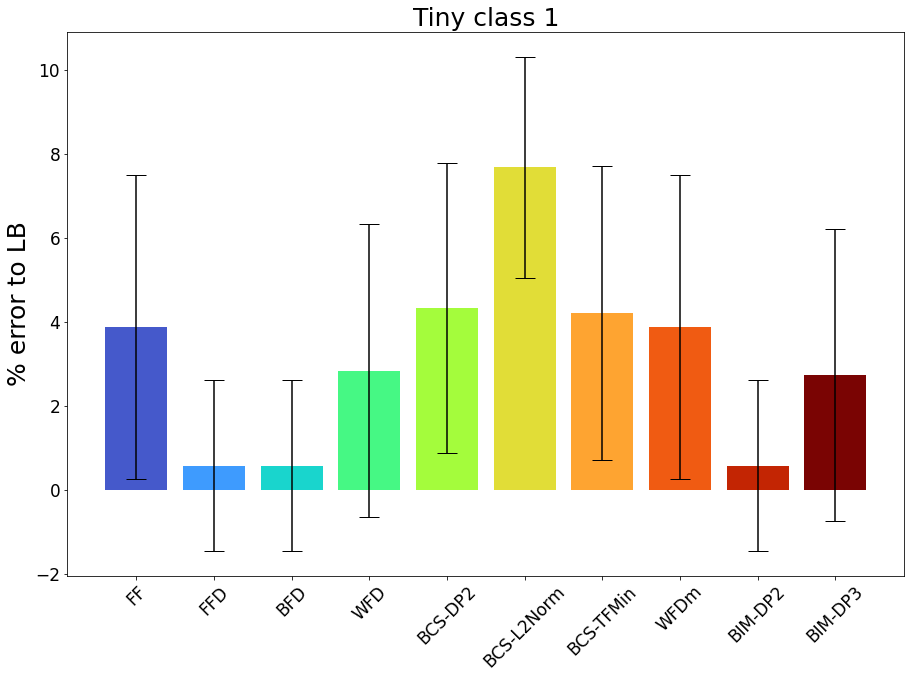

In [37]:
fname = proj_path / "plots/Tiny1_barplot.pdf"
plot_barchart(results_Y1[0], alg_names, "Tiny class 1", fname=fname)

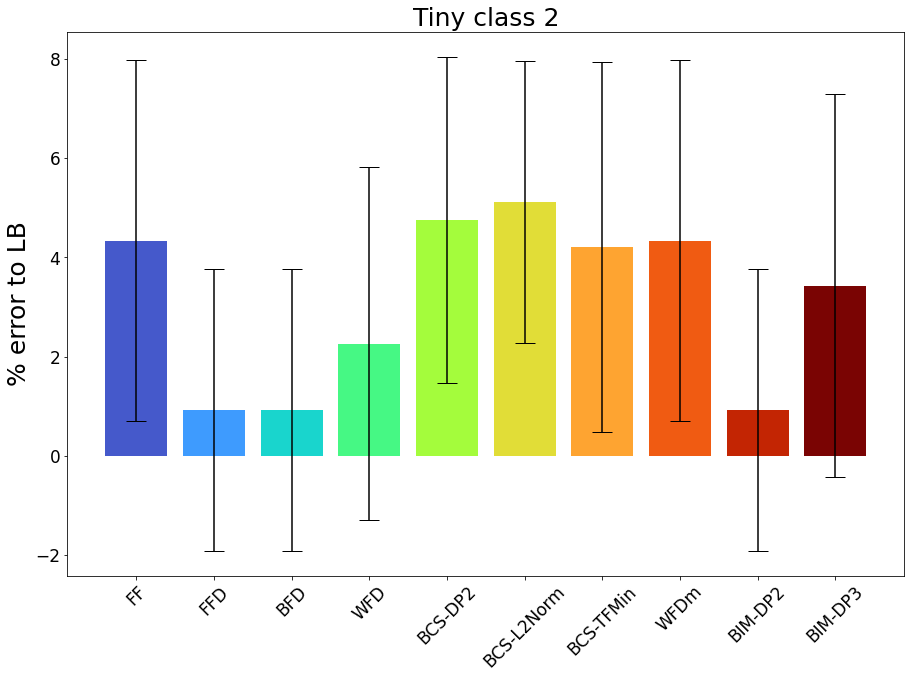

In [36]:
fname = proj_path / "plots/Tiny2_barplot.pdf"
plot_barchart(results_Y2[0], alg_names, "Tiny class 2", fname=fname)

In [99]:
def plot_n_eps(y_data, alg_list, stitle, xlabel, ylabel, filename=None):
    fig = plt.figure(figsize=(10,5))

    color_list = create_small_colors(len(alg_list))

    i = 0
    legend_markers = []
    legend_names = []
    for alg in alg_list:
        plt.plot(y_data[alg], c=color_list[i])
        legend_markers.append(plt.Line2D([0,0],[0,0], color=color_list[i], marker = '.', linestyle=''))
        legend_names.append(alg)
        i+=1
            
    fig.legend(legend_markers, legend_names, numpoints=1, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))

    plt.xticks(y_data.index)
    #plt.xticks([100, 250, 500, 1000, 2500])
    plt.title(stitle, fontsize=FONT_SIZE)
    plt.xlabel(xlabel, fontsize=FONT_SIZE)
    plt.ylabel(ylabel, fontsize=FONT_SIZE)

    plt.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight')

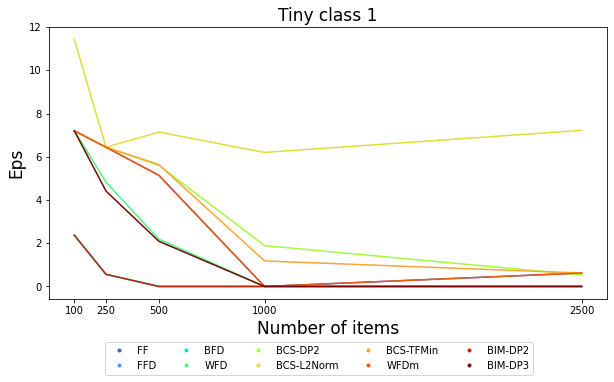

In [100]:
fname = proj_path / "plots/Tiny1_n.pdf"
plot_n_eps(results_Y[0].loc['1'], alg_names,
           f"Tiny class 1", "Number of items", "Eps",
           filename=fname)

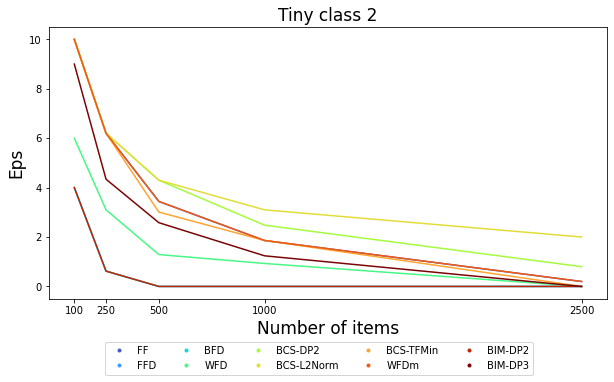

In [101]:
fname = proj_path / "plots/Tiny2_n.pdf"
plot_n_eps(results_Y[0].loc['2'], alg_names,
           f"Tiny class 2", "Number of items", "Eps",
           filename=fname)

In [88]:
df_F["n"] = df_F["instance_name"].apply(lambda x: int(x.split('_')[1][1:]))

In [89]:
df_F.head()

,instance_name,LB,LB_or_OPT,FF,FFD,BFD,WFD,BCS-DP1,BCS-DP2,BCS-NormDP,...,BCS-L2Norm_timems,BCS-TFSum_timems,BCS-TFMin_timems,BIM-DP1_timems,BIM-DP2_timems,BIM-DP3_timems,BIM-NormDP_timems,WFDm_timems,class,n
0,Falkenauer_t120_00,40,40,45,45,45,45,45,45,45,...,0.0,0.0,0.0,66.0,13.0,34.0,75.0,1.0,T,120
1,Falkenauer_t120_01,40,40,45,45,45,45,45,45,45,...,0.0,0.0,0.0,42.0,29.0,27.0,71.0,1.0,T,120
2,Falkenauer_t120_02,40,40,45,45,45,45,45,45,45,...,0.0,0.0,0.0,50.0,34.0,33.0,86.0,1.0,T,120
3,Falkenauer_t120_03,40,40,45,46,46,46,46,45,46,...,0.0,0.0,0.0,49.0,31.0,10.0,75.0,1.0,T,120
4,Falkenauer_t120_04,40,40,45,46,46,46,46,45,46,...,0.0,0.0,0.0,42.0,9.0,9.0,73.0,1.0,T,120


In [90]:
results_F = get_results_by(df_F, alg_names, ["class", "n"], True)

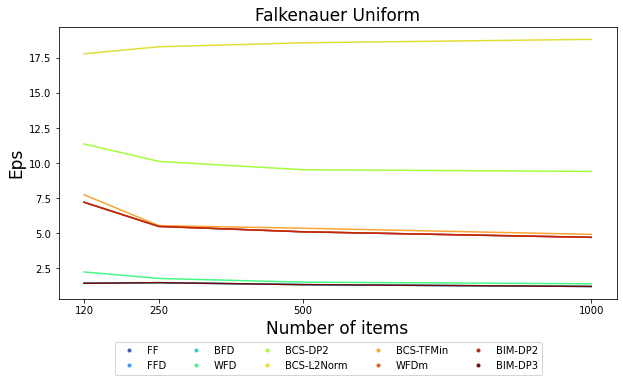

In [103]:
fname = proj_path / "plots/Falkenauer_U.pdf"
plot_n_eps(results_F[0].loc['U'], alg_names,
           f"Falkenauer Uniform", "Number of items", "Eps",
           filename=None)

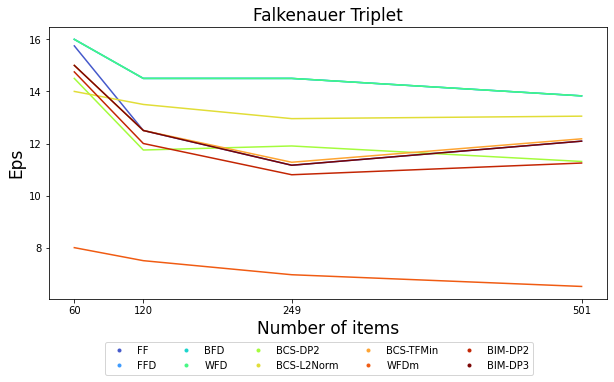

In [104]:
fname = proj_path / "plots/Falkenauer_T.pdf"
plot_n_eps(results_F[0].loc['T'], alg_names,
           f"Falkenauer Triplet", "Number of items", "Eps",
           filename=None)

# OLD cells, merge OPT solutions

In [12]:
map_sheets = {
    "Falkenauer": 0,
    "Scholl": 1,
    "Wascher": 2,
    "Schwerin": 3,
    "Hard28": 4,
    "Irnich": 8
    # Difficult instances are still open
    # (or maybe not, this is not clear)
}

In [ ]:
def merge_opt(filename, sheet_n):
    dfopt = pd.read_excel("Solutions.xlsx", sheet_name = sheet_n)
    dfopt.drop(["Best UB", "Status", "Selected"], axis=1, inplace=True)
    dfopt["Name"] = dfopt["Name"].apply(lambda x: x.rstrip('.txt'))
    dfopt.set_index("Name", inplace=True)
    dfopt.rename(columns={'Best LB':'OPT'}, inplace=True)
    df1 = load_dataset(filename)
    df = df1.merge(dfopt, left_index=True, right_index=True)
    df.index.rename("instance_name", inplace=True)
    return df



### Example

In [ ]:
df = merge_opt("BPPLIB_Falkenauer_dim1.csv", 0)
l = list(df.columns)
l.insert(1, 'OPT')
l = l[:-1]
df.to_csv("BPPLIB_Falkenauer_dim_OPT.csv", sep='\t', columns=l)